# Supplementary Figure 5: Logistic regression

Fitting a logistic regression model to all cells above a given population density. The points used are jittered and shown along with the fitted curve. The dashed lines indicate the optimal threshold as per Supplementary Figure 5 and its corresponding hail probability under the logistic model. Note the differences in the fitted curve between the last three plots and the remaining plots.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(latex2exp, lib.loc = additional_package_lib)
  library(scico)
  library(patchwork)
  library(glmnet)
})

## Utility functions

In [2]:
hss <- function(pred, true){
  # Calculate the Heidke skill score
  #
  # Inputs:
  #  pred  vector
  #        binary predictions
  #  true  vector
  #        binary truth
  # 
  # Outputs:
  #  _     float
  #        heidke skill score
    
  # calculate elements of contingency table
  hits <- sum(pred & true)
  correct_negative <- sum(!pred & !true)
  misses <- sum(!pred & true)
  false_alarms <- sum(pred & !true)
    
  # number of predictions
  total <- length(true)
  
  # number of expected correct predictionrs 
  expected_correct <- (1 / total) * ((hits + misses) * (hits + false_alarms) + 
                                     (correct_negative + misses) * (correct_negative + false_alarms))
  
  # heidke skill score
  ((hits + correct_negative) - expected_correct) / (total - expected_correct)
}

test_thresh <- function(x, true){
  # Function to test every threshold on predictors x compared with 
  # truth true
  #
  # Inputs:
  #  x     vector
  #        the continous predictor
  #  true  vector
  #        the binary true and false occurrences 
  # 
  # Outputs:
  #  _     tibble
  #        two columns, first being the threshold value (ordered) and
  #        the second being the resulting heidke skill score
    
  # sort x to get unique threshold
  unique_x <- sort(unique(x))
  # calculate number of thresholds
  num_thresh <- length(unique_x)
  # pre-allocate for results
  res <- rep(0, num_thresh)

  # loop over all thresholds
  for (i in 1:num_thresh) {
    # predictions binary based on threshold
    pred <- x > unique_x[i]
    # calculate heidke skill score
    res[i] <- hss(pred, true)
  }
  
  # package into tibble
  tibble(thresh = unique_x, res = res)
}

logistic_regression_analysis <- function(pop_threshold){
  # Function to plot the logist regression fit using only data above
  # a given population density threhsold
  #
  # Inputs:
  #  pop_threshold  float
  #                 minimum population density to be included in analysis
  # 
  # Outputs:
  #  _              ggplot object
  #                 logistic regression of reports against MESH
  #                 location of optimal threshold highlighted
    
  # filtering the data
  most_pop_cell <- clean_data %>%
    filter(pop_dens >= pop_threshold)

  # making matrices for logistic regression
  x_mat <- cbind(1, most_pop_cell$mesh)
  y_mat <- most_pop_cell$report

  # fitting logistic regression
  fit <- glmnet(x_mat, y_mat, family = "binomial")
    
  # testing all thresholds
  res <- test_thresh(most_pop_cell$mesh, most_pop_cell$report)
    
  # finding optimum threshold
  opt_thresh <- res %>%
    filter(res == max(res)) %>%
    pull(thresh)
  # predicting prob at this threshold
  prob_at_opt_thresh <- predict(fit, newx = cbind(1, opt_thresh), type = "response", s = 0)
  
  # plot colour
  plot_colour <- scico(1, begin = 0.2, end = 0.8, palette = "batlow")

  # plotting
  tibble(mesh = seq(min(most_pop_cell$mesh), max(most_pop_cell$mesh), length.out = 100)) %>%
    # predictions of the model onto range of MESH
    mutate(pred = predict(fit, newx = cbind(1, mesh), type = "response", s = 0)) %>%
    ggplot() + 
    geom_line(aes(x = mesh, y = pred), color = plot_colour) + 
    # jittering the observed MESH values for clarity
    geom_jitter(aes(x = mesh, y = report), data = most_pop_cell, width = 0, height = 0.01, color = plot_colour) +
    # label
    xlab("MESH [mm]") +
    ylab("P(Hail = 1 | MESH)") +
    ggtitle(TeX(paste0("Population density$\\geq$", round(pop_threshold), " people km$^{-2}$"))) +
    # consistent limits for all plots
    xlim(0, 110) +
    # adding in an indicator of optimal threshold
    geom_path(aes(x = x, y = y), data = tibble(x = c(opt_thresh, opt_thresh, 0), 
                                               y = c(0, prob_at_opt_thresh, prob_at_opt_thresh)),
             linetype = "dashed")
}

## Reading data

In [3]:
clean_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_diameter_",
                              "comment_radar_66_variable_mesh_t_x_y_binned_t_2010-01-01_",
                              "2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_-26.50_0.25.csv"),
                      col_types = "nnTnnnnnnncnnfffff") # letting report be numeric for comparison

## Plotting

Will raise error on one plot where there is minimal data.

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


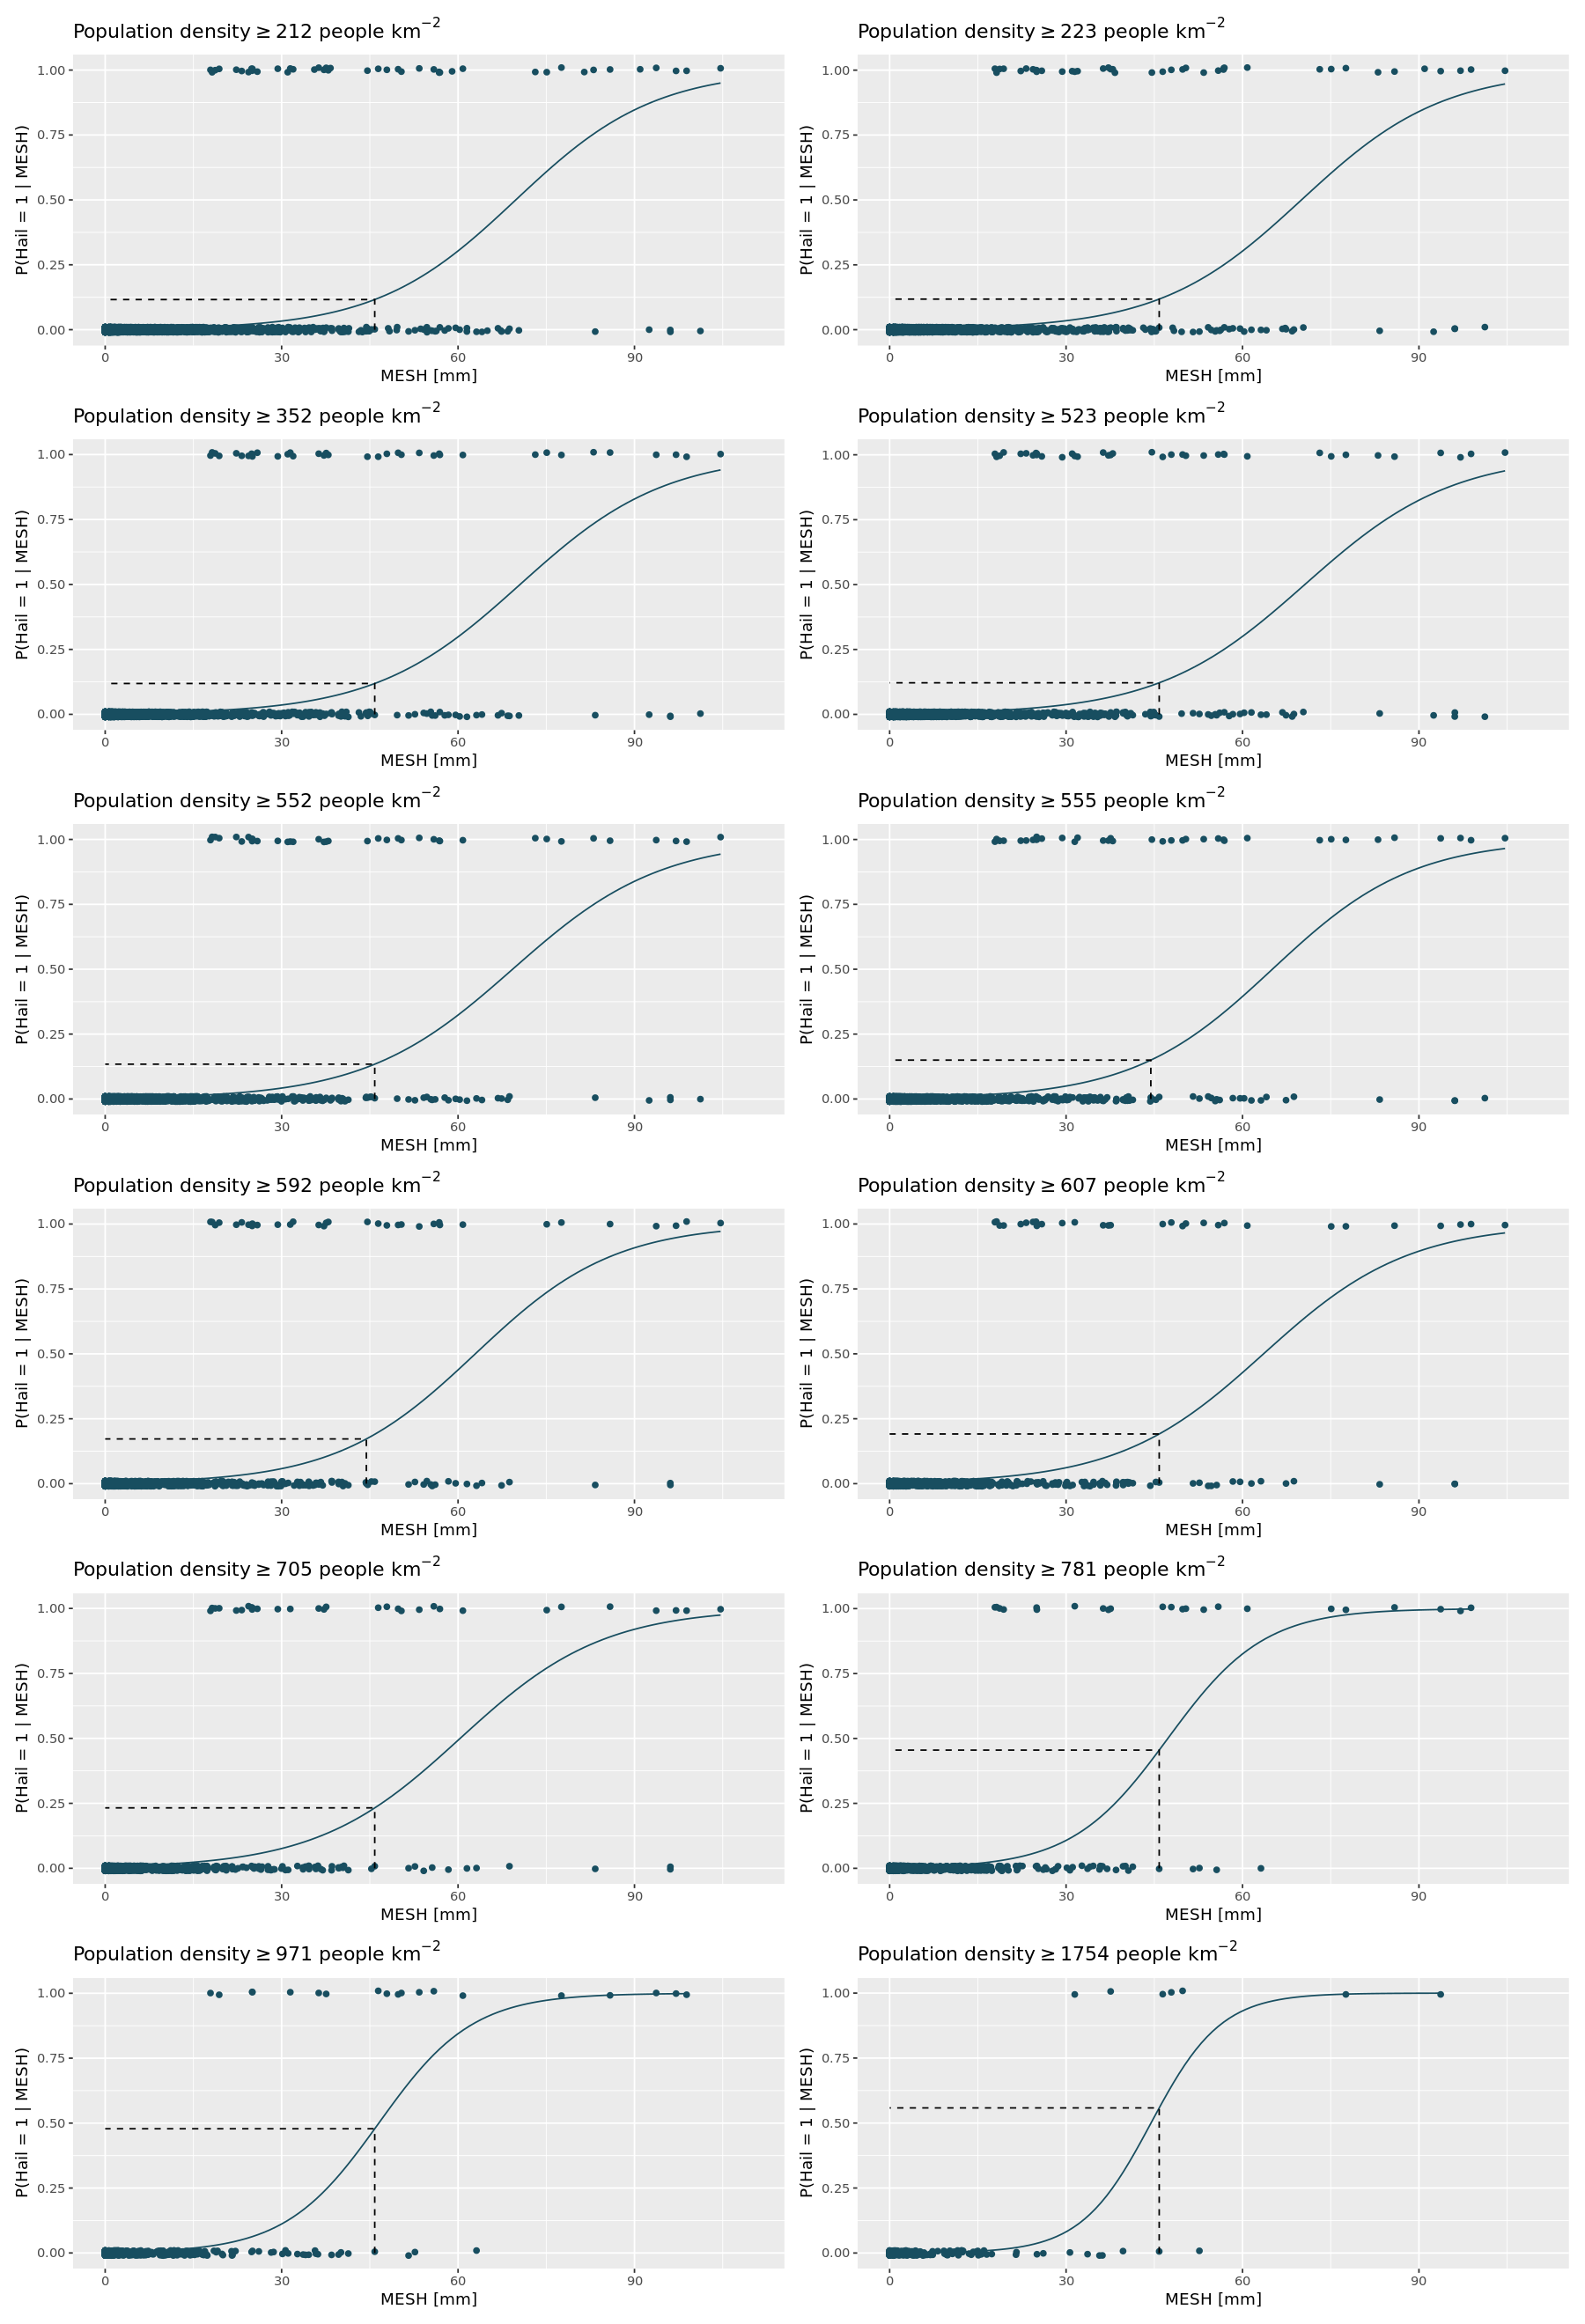

In [4]:
# plot size
options(repr.plot.width = 15, repr.plot.height = 22)

# getting highest densities to sort
tail(sort(unique(clean_data$pop_dens)), 12) %>%
  # applying logistic regression
  map(logistic_regression_analysis) %>%
  # wrapping into plot
  wrap_plots(nrow = 6)